In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plutils import gtf

In [4]:
MINE = '/net/topmed10/working/porchard/rnaseq/work/test-crossmap/results/gene-mappability/gene_mappability/gene_mappability.txt'
THEIRS = '/net/topmed10/working/porchard/rnaseq/data/mappability/hg38_gene_mappability.txt.gz'
GTF = '/net/topmed10/working/porchard/rnaseq/work/test-crossmap/gencode.v26.annotation.gtf'

In [5]:
gtf_df = gtf.gtf_to_df(GTF)
gtf_df = gtf_df[gtf_df.feature=='gene']
gtf_df['gene_id'] = gtf_df.attributes.map(lambda x: gtf.parse_attributes(x)['gene_id'])
gtf_df.head()

,chrom,source,feature,start,end,score,strand,frame,attributes,gene_id
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc...",ENSG00000223972.5
12,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc...",ENSG00000227232.5
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""...",ENSG00000278267.1
28,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lincRN...",ENSG00000243485.5
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""...",ENSG00000284332.1


In [6]:
gene_id_to_chrom = dict(zip(gtf_df.gene_id, gtf_df.chrom))

In [7]:
mine = pd.read_csv(MINE, sep='\t', header=None, names=['gene_id', 'mine'])
theirs = pd.read_csv(THEIRS, sep='\t', header=None, names=['gene_id', 'theirs'])

comb = mine.merge(theirs)
PAR_Y = comb[comb.gene_id.str.contains('PAR_Y')].gene_id.to_list()
PAR_X = [i.replace('_PAR_Y', '') for i in PAR_Y]
comb['chrom'] = comb.gene_id.map(gene_id_to_chrom)
comb['delta'] = (comb.mine - comb.theirs).abs()
comb['in_par'] = comb.gene_id.isin(PAR_Y + PAR_X)
assert(len(comb) == len(mine))
assert(len(comb) == len(theirs))
comb.head()

,gene_id,mine,theirs,chrom,delta,in_par
0,ENSG00000000457.13,0.965472,0.965447,chr1,2.491131e-05,False
1,ENSG00000000460.16,0.958862,0.960331,chr1,1.468471e-03,False
2,ENSG00000000938.12,0.999773,0.999774,chr1,7.670689e-07,False
3,ENSG00000000971.15,0.950313,0.950313,chr1,0.000000e+00,False
4,ENSG00000001460.17,0.991287,0.991287,chr1,5.017897e-07,False


In [8]:
(comb.delta<=0.01).value_counts()

True     56478
False     1741
Name: delta, dtype: int64

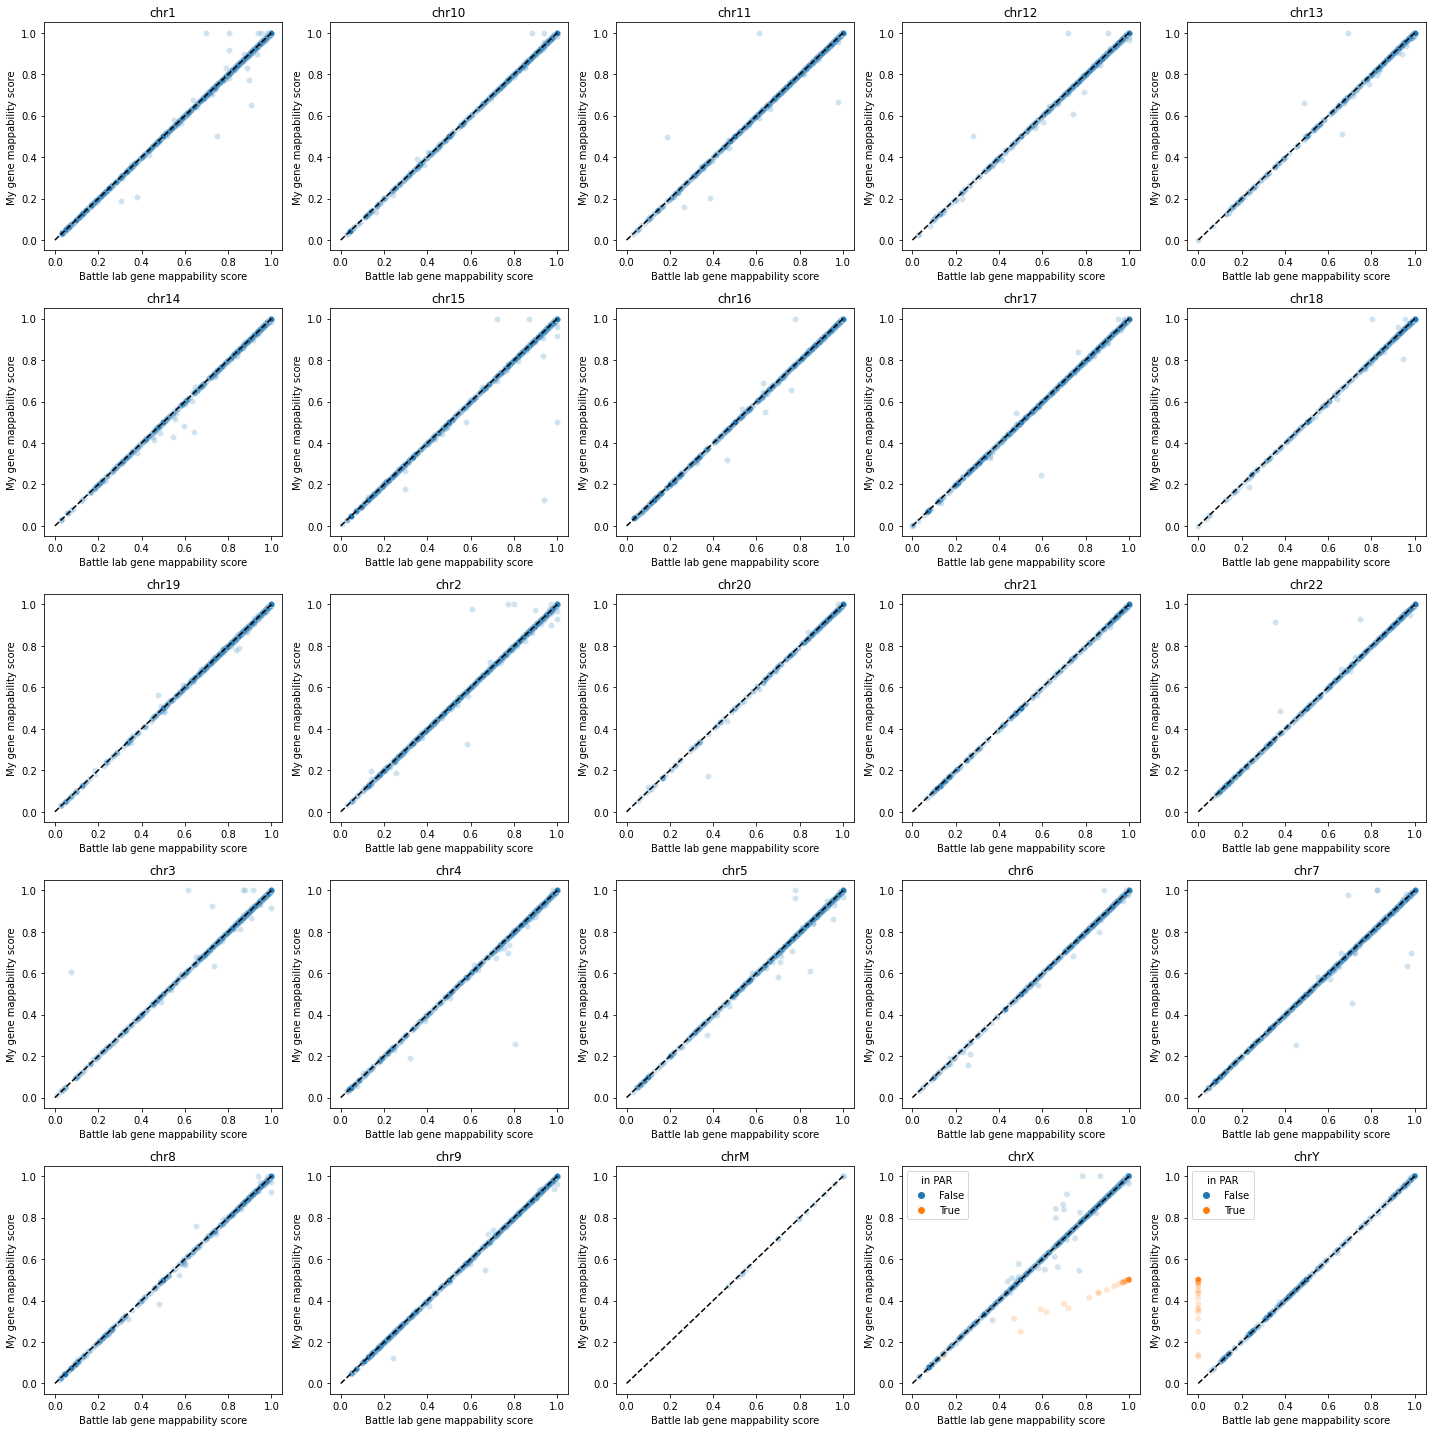

In [11]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(5*4, 5*4))
ax_idx = 0
for chrom, df in comb.groupby('chrom'):
    ax = axs.flatten()[ax_idx]
    ax_idx += 1
    #fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], ls='--', color='black')
    if chrom in ['chrX', 'chrY']:
        sns.scatterplot(x='theirs', y='mine', data=df, ax=ax, alpha=0.2, hue='in_par')
        ax.legend().set_title('in PAR')
    else:
        sns.scatterplot(x='theirs', y='mine', data=df, ax=ax, alpha=0.2)
    ax.set_title(chrom)
    ax.set_xlabel('Battle lab gene mappability score')
    ax.set_ylabel('My gene mappability score')

fig.tight_layout()